# Deep Learning Assignment Part A: Convolutional Neural Network

## Prediction Task

> The objective is to make an image classifier using a deep learning network.

## Dataset

You are to use the Fashion MINST dataset.

```py
tf.keras.datasets.fashion_mnist.load_data()
```

## Tasks

1. Write the code to solve the prediction task. You would be using TensorFlow 2.0/Keras, but if you'd prefer to work with some other toolkit such as MXNET or PyTorch, that is fine.
2. Write a Jupyter notebook detailing your implementation, your experiments and analysis. Remember to also save the jupyter notebook as a HTML file after running it.
3. Create a set of slides with the highlights of your Jupyter notebook. Explain the entire deep learning process you went through, data exploration, data cleaning, feature engineering, and model building and evaluation. Write your conclusions.


In [1]:
# Import Relevant Libraries/Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Matplotlib Stylings
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['image.cmap'] = 'gray_r'
plt.rcParams['figure.autolayout'] = True
plt.style.use('fivethirtyeight')

In [3]:
# Checking if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16053041618226926660
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2918357403
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15989024002860918999
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
# Import Dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (60000, 28, 28) y_train: (60000,)
X_test: (10000, 28, 28) y_test: (10000,)


## Exploratory Data Analysis

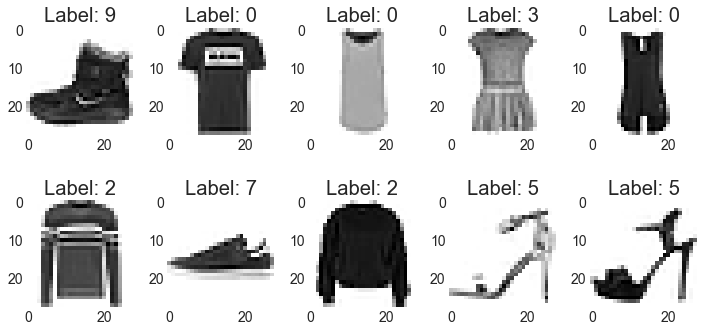

In [5]:
# Display the first 10 images in the training set.
with plt.style.context('seaborn-dark'):
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    for idx, subplot in zip(zip(X_train, y_train), ax.ravel()):
        subplot.imshow(idx[0], cmap='gray_r')
        subplot.set_title('Label: {}'.format(idx[1]))
    plt.show()

In [6]:
pd.Series(y_train.reshape(-1)).value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

## Data Preprocessing


### Image Augmentation



### One-Hot Encoding for Categorical Cross-Entropy

Since this is a multi-class image classification task, most likely I would have to use for the Categorical Cross-Entropy as the loss function. For categorical cross-entropy, the Neural Network would output a 1-Dimensional One Hot encoded vector. As such, I would need to perform One-Hot encoding on the labels.

![](./assets/img/onehot_encoding.svg)

In [7]:
from tensorflow.keras.utils import to_categorical

# Convert the labels to categorical one-hot encoding

y_train_oh = to_categorical(y_train, 10)
y_test_oh = to_categorical(y_test, 10)

## Implementing a Baseline CovNet

The main purpose of this section of the notebook is to lay out a basic fundamental sequence and to see the performance of a baseline model.

### The Sequence

1. The first layer would serve as both an input and a `Reshape` layer, reshaping a (28, 28) image into a 3D tensor of shape (28, 28, 1). Furthermore, `Rescaling` the input image serves as normalization on to the pixel intensity values, which is important for the model to converge.

$$ X_1 = \frac{X}{255} $$

2. The second layer is a `Conv2D` layer, which is a convolutional layer that performs a 2D convolution over the input. The convolution kernel has a shape of (3, 3) and the number of filters is 32. The strides are set to (1, 1). The padding is set to `same`, which means that the output image is the same size as the input image. The activation function is set to `relu`, to induce a non-linearity in the output. Max Pooling is performed to downsample the output of the feature map, extracted from the convolution layer.

![CNN Layer](./assets/img/cnn_layer.gif)

3. The third layer is a `Flatten` layer, which flattens the output of the previous layer into a 1D tensor. This output is later transferred to a dense output layer with `softmax` activation function, for multi-class classification.

![Flatten Layer](./assets/img/image_output_layer.gif)

4. At last, the model is compiled with `Adam` (Adaptive momentum estimation) Optimization method to iteratively update the network weights based on the training data. The loss function is set to `Categorical Cross Entropy`, as the predictive task is a multi-class classification.

$$\mathrm{Loss} = -\sum_{i=1}^{\mathrm{output \atop size}} y_i \cdot \mathrm{log}\; {\hat{y}}_i$$

![Categorical Cross Entropy](./assets/img/categorical_crossentropy_setup.svg)

In [8]:
# Import Keras Libraries
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [9]:
baseline_cnn = Sequential(name='Baseline-CovNet')

"""
Preprocessing
    Reshape: Reshapes the (28, 28) image into a 3D Tensor of size (28, 28, 1)
    Rescaling: Normlalization Process to turn a pixel value to be between 0 and 1
"""
baseline_cnn.add(Reshape((28, 28, 1), input_shape=(28, 28)))
baseline_cnn.add(Rescaling(1./255))

"""
Convolutional Layer - 32 Neurons
    Conv2D: Creates a feature map of size (28, 28, 32) and apply non-linearity
    MaxPooling2D:  Downsample the feature map by 2x2
"""
baseline_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
baseline_cnn.add(MaxPooling2D(pool_size=(2, 2)))

"""
Output Layer
    Flatten: Flattens the feature map to a 1D tensor
    Softmax: Applies the softmax activation function to the output
            for multi-class classification
"""
baseline_cnn.add(Flatten())
baseline_cnn.add(Dense(10, activation='softmax'))


In [10]:
# prepare model checkpoint, in case my computer BSOD
callbacks_fn = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./assets/Keras/Baseline-CNN.{epoch:02d}-{val_loss:.2f}.h5')
]

In [11]:
# Compile with Adam Optimizer, Cross Entropy loss function, and accuracy as the evaluation metrics
baseline_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_cnn.summary()

Model: "Baseline-CovNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_______________________________________________

In [12]:
%%time
baseline_cnn_fit = baseline_cnn.fit(X_train, y_train_oh, 
                                   epochs=10, validation_split=0.2, 
                                   batch_size=64, callbacks=callbacks_fn)

Epoch 1/10
750/750 [==============================] - 9s 7ms/step - loss: 0.5135 - accuracy: 0.8224 - val_loss: 0.3988 - val_accuracy: 0.8588
Epoch 2/10
750/750 [==============================] - 15s 20ms/step - loss: 0.3518 - accuracy: 0.8780 - val_loss: 0.3595 - val_accuracy: 0.8736
Epoch 3/10
750/750 [==============================] - 15s 20ms/step - loss: 0.3148 - accuracy: 0.8898 - val_loss: 0.3163 - val_accuracy: 0.8890
Epoch 4/10
750/750 [==============================] - 15s 20ms/step - loss: 0.2902 - accuracy: 0.8986 - val_loss: 0.3074 - val_accuracy: 0.8895
Epoch 5/10
750/750 [==============================] - 16s 21ms/step - loss: 0.2708 - accuracy: 0.9057 - val_loss: 0.2961 - val_accuracy: 0.8947
Epoch 6/10
750/750 [==============================] - 15s 19ms/step - loss: 0.2583 - accuracy: 0.9100 - val_loss: 0.2861 - val_accuracy: 0.9013
Epoch 7/10
750/750 [==============================] - 15s 20ms/step - loss: 0.2453 - accuracy: 0.9138 - val_loss: 0.2880 - val_accuracy: 0

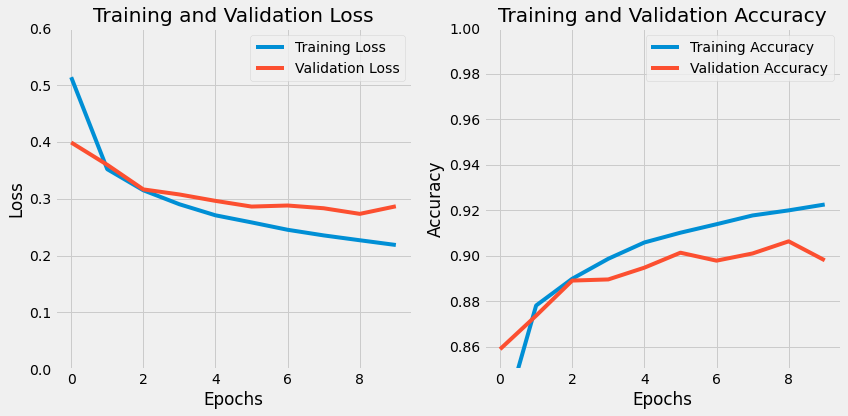

In [21]:
# Plot Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(baseline_cnn_fit.history['loss'], label='Training Loss')
ax1.plot(baseline_cnn_fit.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim(bottom=0.0, top=0.6)
ax1.legend()

ax2.plot(baseline_cnn_fit.history['accuracy'], label='Training Accuracy')
ax2.plot(baseline_cnn_fit.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(bottom=0.85, top=1.0)
ax2.legend()

plt.show()

### Baseline Model Evaluation

In my opinion, even though the model is producing a high accuracy for its baseline, the deviation between the training and validation indicates some variance in the model. The loss function is also hovering around 0.3, which indicates that the model could be improved. I believe the next step should be improving the model accuracy performance and reduce overfitting.

## Implementing a High End Baseline with InceptionV3 & Transfer Learning

The objective of this section is to implement a high end baseline to see what is the upper boundary of the predictive task. It is important to have both a low end and a high end baseline for predictive modelling.

### Typical Transfer Learning Workflow

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train your new model on your new dataset.


In [14]:
from tensorflow.keras.applications import InceptionV3


## Building a Deeper CovNet v2



In [15]:
# Building a ConvNet
model = Sequential()

# Input Layer
model.add(Input(shape=(28, 28)))

# Preprocessing - Pixel Normalization and Reshaping
model.add(Rescaling(1./255))
model.add(Reshape(target_shape=(28, 28, 1)))

# Cov Layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense Layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(10, activation='softmax'))

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 28, 28)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0

In [17]:
%%time
history = model.fit(X_train, y_train_oh, epochs=10, validation_split=0.2, batch_size=64, callbacks=callbacks_fn)

Epoch 1/10
750/750 [==============================] - 191s 247ms/step - loss: 0.8455 - accuracy: 0.7122 - val_loss: 0.4436 - val_accuracy: 0.8428
Epoch 2/10
750/750 [==============================] - 171s 228ms/step - loss: 0.4432 - accuracy: 0.8551 - val_loss: 0.2874 - val_accuracy: 0.8993
Epoch 3/10
750/750 [==============================] - 136s 182ms/step - loss: 0.3697 - accuracy: 0.8816 - val_loss: 0.2793 - val_accuracy: 0.9038
Epoch 4/10
750/750 [==============================] - 169s 226ms/step - loss: 0.3306 - accuracy: 0.8941 - val_loss: 0.2427 - val_accuracy: 0.9176
Epoch 5/10
750/750 [==============================] - 184s 245ms/step - loss: 0.3074 - accuracy: 0.9022 - val_loss: 0.2417 - val_accuracy: 0.9176
Epoch 6/10
750/750 [==============================] - 169s 225ms/step - loss: 0.2897 - accuracy: 0.9070 - val_loss: 0.2285 - val_accuracy: 0.9222
Epoch 7/10
750/750 [==============================] - 56s 75ms/step - loss: 0.2723 - accuracy: 0.9134 - val_loss: 0.2348 - v

In [18]:
model.save('./assets/Model/CNNv2.h5')

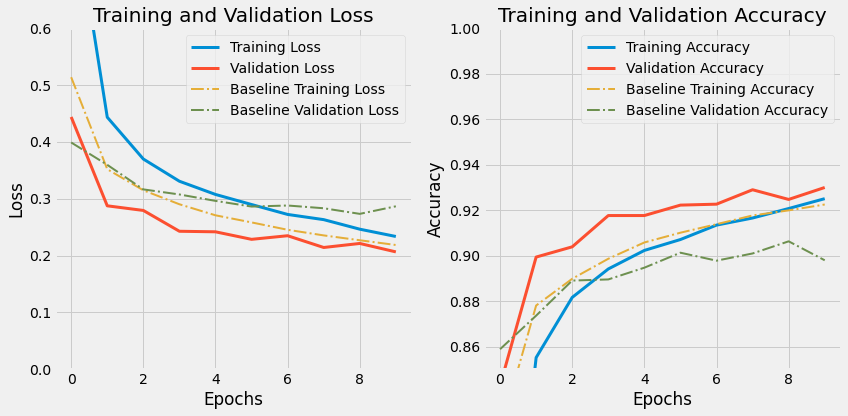

In [41]:
# Plot Learning Curves
# Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], label='Training Loss', linewidth=3)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=3)
ax1.plot(baseline_cnn_fit.history['loss'], label='Baseline Training Loss', linestyle='-.', linewidth=2)
ax1.plot(baseline_cnn_fit.history['val_loss'], label='Baseline Validation Loss', linestyle='-.', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_ylim(bottom=0.0, top=0.6)
ax1.legend()

# Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=3)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=3)
ax2.plot(baseline_cnn_fit.history['accuracy'], label='Baseline Training Accuracy', linestyle='-.', linewidth=2)
ax2.plot(baseline_cnn_fit.history['val_accuracy'], label='Baseline Validation Accuracy', linestyle='-.', linewidth=2)
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(bottom=0.85, top=1.0)
ax2.legend()

plt.show()

In [ ]:
# Validation Performing Better than Training
# Likely due to adding too much Dropout Layers